In [47]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1

def add_metadata(fname, d):
    match = re.search('width_mult_\d+(\.\d+)?', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = float(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
        
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
        
    match = re.search('seed_\d+', fname)
    if match:
        s = match.group(0)[len("seed_"):]
        d["seed"] = int(s)
    else:
        d["seed"] = None
    
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
        
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
        
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d


def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath_ = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath_)
            d = add_metadata(fp, d)
            args_path = open(os.path.join(fpath, "args.json"))
            args = json.load(args_path)
            d["width"] = args["width"]
            d["name"] = fp
            final_d.append(d)
    return final_d


def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        
        for k in d["metrics"].keys():
            try:
                loss_d[k] = d["metrics"][k]
            except Exception:
                continue
        # try:
        #     if train:
        #         loss_d["train_loss"] =  d["metrics"]["train_loss"]
        #         if acc:
        #             if "train_acc" in d["metrics"].keys():
        #                 loss_d["train_acc"] =  d["metrics"]["train_acc"]
        #         if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
        #             loss_d["trace"] = d["metrics"]["trace"]
        #         if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
        #             loss_d["top_eig"] = d["metrics"]["top_eig"]
        #     else:
        #         loss_d["test_loss"] =  d["metrics"]["test_loss"]
        #         loss_d["test_acc"] =  d["metrics"]["test_acc"]
        for eigi in range(10):
            loss_d[f"top_eig_{eigi}"] =  d["metrics"][f"top_eig_{eigi}"]
        loss_d["lr"] = d["lr"]
        loss_d["width_mult"] = d["width_mult"]
        loss_d["width"] = d["width"]
        loss_d["depth_mult"] = d["depth_mult"]
        loss_d["step"] = loss_d.index
        loss_d["beta"] = d["beta"]
        loss_d["gamma_zero"] = d["gamma_zero"]
        loss_d["k_layers"] = d["k_layers"]
        loss_d["batch_size"] = d["batch_size"]
        loss_d["seed"] = d["seed"]
        ds.append(loss_d)
    return pd.concat(ds, axis=0)


def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size','width', 'seed', 'ntk_eig_0', 'ntk_eig_4, ntk_eig_9')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [48]:
folder_path = "/home/ameterez/work/nips2024/debug_depth_more_warmup_very_long_top10/"
width_mult = True

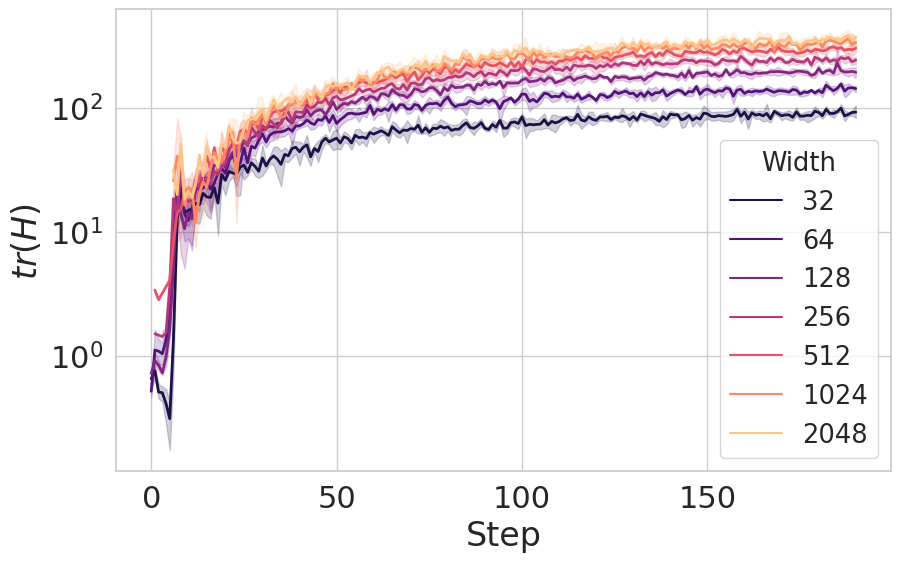

In [39]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
fig = plt.figure(figsize = (10,6))

metric = "trace"
epoch = 9
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

df = df[~df[metric].isna()]

# df = df[df[metric] > 5e-3]


if width_mult:
    df["width"] = df["width_mult"] * 64

df["Width"] = df["width"]

df = df[df["Width"] != 4096]
#df = df[df["lr"] == 8] 

#df = df.groupby(["Depth", "seed", "lr"], as_index=False).rolling(3).mean()
df = df[~df[metric].isna()]
#df["step"] = df["step"] / df["step"].max() * epoch

df["coeff"] = df["Width"]
df[metric] = df[metric] * df["coeff"]

# df_best_lr = df[df["step"] == max(df["step"])]
# df_best_lr = df_best_lr.reset_index(drop=True)
# df_best_lr = df_best_lr.loc[df_best_lr.groupby(["width_mult", "Depth"])["train_loss"].idxmin()]
# lrs = df_best_lr[df_best_lr["Depth"].isin([3, 24])]["lr"]
# df[metric] = df[metsric].rolling(2).mean()
# df = df.dropna()

df = df.astype({"Width": np.int32})
df[r"$\lambda$"] = df[metric]
df["Step"] = df["step"]

# df_max = df[df["Width"] == df["Width"].max()]
# df = df[df["Width"] != df["Width"].max()]

n_colors = len(df["Width"].unique())

palette = sns.color_palette("magma", n_colors=n_colors)
ax = sns.lineplot(data=df, x='Step', y=r"$\lambda$", hue="Width", markersize=8, palette=palette, legend=True, linewidth=2)
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
# df_max_width = df_max["Width"].max()
# df_max["Inf Width"] = df_max["Width"]
# ax = sns.lineplot(data=df_max, x='Step', y=r"$\lambda$", hue="Inf Width", markersize=8, palette=['r'], legend=True, linewidth = 3)


# lrs = df["lr"].unique()
# print(lrs)
# plt.hlines(2/lrs, 0, df["Step"].max(), linestyle="dashed")

# handlers, labels = ax.get_legend_handles_labels()

# print(labels)
# new_handlers, new_labels = [], []
# for handle, label in zip(handlers, labels):
#     print(str(df_max_width))
#     if label == str(df_max_width):
#         print("Hello")
#         new_handlers.append(handle)
#         new_labels.append(r'$\infty$')
#     elif label != "Inf Width":
#         new_handlers.append(handle)
#         new_labels.append(label)

#ax.legend(new_handlers, new_labels, bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
legend = ax.legend(title="Width", prop={"size":18.5})
plt.setp(legend.get_title(),fontsize=18.5)

plt.ylabel("$tr(H)$")
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0.8, 2.6)
#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
#plt.ylim(0.8, 2.4)
#plt.savefig("Figures/cifar10_conv_sharpness_ntk_width_data_augm_bs128.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Figures/Neurips/not_strong_cons_trace_cifar10_resnet_conv_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')

['32', '64', '128', '256', '512', '1024', '2048', '4096']
4096
4096
4096
4096
4096
4096
4096
4096
Hello


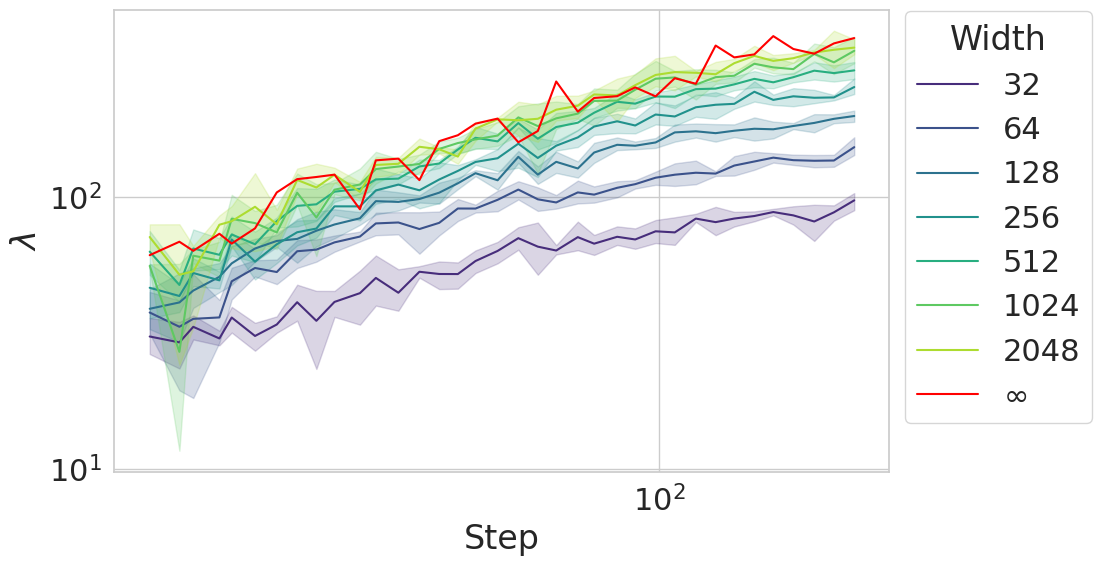

In [20]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
fig = plt.figure(figsize = (10,6))

metric = "trace"
epoch = 9
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

df = df[~df[metric].isna()]

df = df[df[metric] > 1e-2]

steps = np.unique(np.logspace(np.log10(1),np.log10(400), num=100, base=10).astype(int))
df = df[df["step"].isin(steps)]
df = df[df["step"] > 20]

if width_mult:
    df["width"] = df["width_mult"] * 64

df["Width"] = df["width"]
#df = df[df["lr"] == 8] 

#df = df.groupby(["Depth", "seed", "lr"], as_index=False).rolling(3).mean()
df = df[~df[metric].isna()]
#df["step"] = df["step"] / df["step"].max() * epoch

df["coeff"] = df["Width"]
df[metric] = df[metric] * df["coeff"]

# df_best_lr = df[df["step"] == max(df["step"])]
# df_best_lr = df_best_lr.reset_index(drop=True)
# df_best_lr = df_best_lr.loc[df_best_lr.groupby(["width_mult", "Depth"])["train_loss"].idxmin()]
# lrs = df_best_lr[df_best_lr["Depth"].isin([3, 24])]["lr"]
# df[metric] = df[metsric].rolling(2).mean()
# df = df.dropna()

df = df.astype({"Width": np.int32})
df[r"$\lambda$"] = df[metric]
df["Step"] = df["step"]

df_max = df[df["Width"] == df["Width"].max()]
df = df[df["Width"] != df["Width"].max()]

n_colors = len(df["Width"].unique())


ax = sns.lineplot(data=df, x='Step', y=r"$\lambda$", hue="Width", markersize=8, palette=sns.color_palette("viridis", n_colors=n_colors), legend=True)
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
df_max_width = df_max["Width"].max()
df_max["Inf Width"] = df_max["Width"]
ax = sns.lineplot(data=df_max, x='Step', y=r"$\lambda$", hue="Inf Width", markersize=8, palette=['r'], legend=True)


# lrs = df["lr"].unique()
# print(lrs)
# plt.hlines(2/lrs, 0, df["Step"].max(), linestyle="dashed")

handlers, labels = ax.get_legend_handles_labels()

print(labels)
new_handlers, new_labels = [], []
for handle, label in zip(handlers, labels):
    print(str(df_max_width))
    if label == str(df_max_width):
        print("Hello")
        new_handlers.append(handle)
        new_labels.append(r'$\infty$')
    elif label != "Inf Width":
        new_handlers.append(handle)
        new_labels.append(label)

ax.legend(new_handlers, new_labels, bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
plt.ylabel("$\lambda$")
plt.yscale('log')
plt.xscale('log')
#plt.ylim(0.8, 2.6)
#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
#plt.ylim(0.8, 2.4)
# ax.grid(True, which='minor', linestyle='-', linewidth=0.5, color='gray')
# ax.set_xticklabels([])
# #ax.tick_params(axis='x', which='both', labelbottom=False)

# ax.set_yticklabels([])

# print(ax.get_xticks())
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
# ax.set_xticklabels(xlabels)
# from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, LogLocator, LogFormatter
# ax.xaxis.set_minor_locator(MultipleLocator(10)) 
# ax.xaxis.set_minor_locator(plt.MaxNLocator(2))
# ax.yaxis.set_minor_locator(plt.MaxNLocator(4))
#plt.savefig("Figures/cifar10_conv_sharpness_ntk_width_data_augm_bs128.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')
plt.savefig("Figures/Neurips/not_strong_cons_trace_loglog_cifar10_resnet_conv_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')

[0.7]
['32', '64', '128', '256', '512', '1024', '2048']
2048
2048
2048
2048
2048
2048
2048
Hello


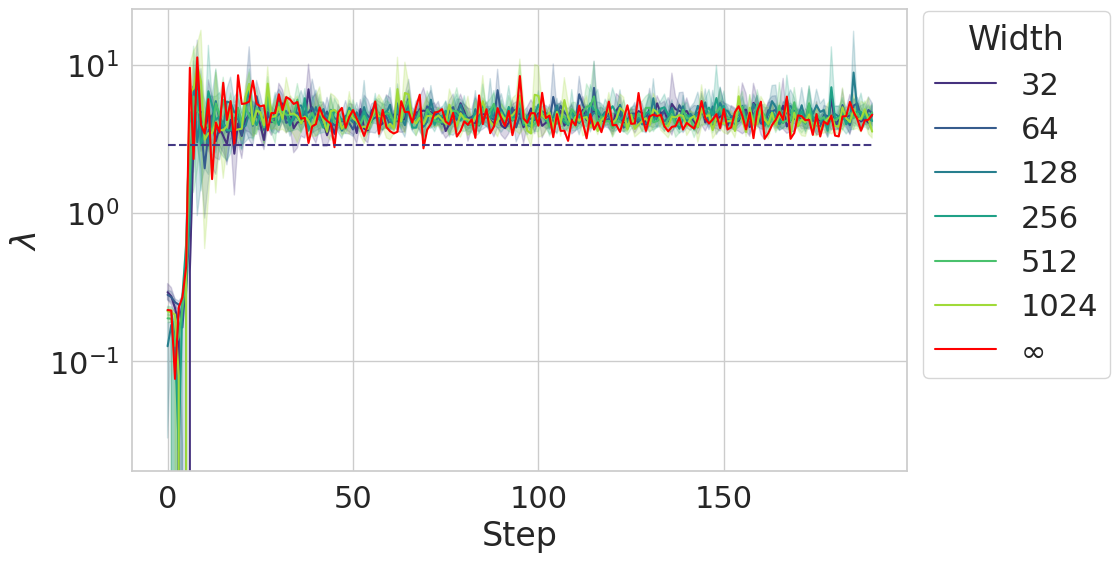

In [26]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
fig = plt.figure(figsize = (10,6))

metric = "top_eig_0"

epoch = 9
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

df = df[~df[metric].isna()]

if width_mult:
    df["width"] = df["width_mult"] * 64

df["Width"] = df["width"]
#df = df[df["lr"] == 8] 

#df = df.groupby(["Depth", "seed", "lr"], as_index=False).rolling(3).mean()
df = df[~df[metric].isna()]
#df["step"] = df["step"] / df["step"].max() * epoch

df["coeff"] = df["Width"]
df[metric] = df[metric] * df["coeff"]

# df_best_lr = df[df["step"] == max(df["step"])]
# df_best_lr = df_best_lr.reset_index(drop=True)
# df_best_lr = df_best_lr.loc[df_best_lr.groupby(["width_mult", "Depth"])["train_loss"].idxmin()]
# lrs = df_best_lr[df_best_lr["Depth"].isin([3, 24])]["lr"]
# df[metric] = df[metsric].rolling(2).mean()
# df = df.dropna()

df = df.astype({"Width": np.int32})
df[r"$\lambda$"] = df[metric]
df["Step"] = df["step"]

df_max = df[df["Width"] == df["Width"].max()]
df = df[df["Width"] != df["Width"].max()]

n_colors = len(df["Width"].unique())


ax = sns.lineplot(data=df, x='Step', y=r"$\lambda$", hue="Width", markersize=8, palette=sns.color_palette("viridis", n_colors=n_colors), legend=True)
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
df_max_width = df_max["Width"].max()
df_max["Inf Width"] = df_max["Width"]
ax = sns.lineplot(data=df_max, x='Step', y=r"$\lambda$", hue="Inf Width", markersize=8, palette=['r'], legend=True)


lrs = df["lr"].unique()
print(lrs)
plt.hlines(2/lrs, 0, df["Step"].max(), linestyle="dashed")

handlers, labels = ax.get_legend_handles_labels()

print(labels)
new_handlers, new_labels = [], []
for handle, label in zip(handlers, labels):
    print(str(df_max_width))
    if label == str(df_max_width):
        print("Hello")
        new_handlers.append(handle)
        new_labels.append(r'$\infty$')
    elif label != "Inf Width":
        new_handlers.append(handle)
        new_labels.append(label)

ax.legend(new_handlers, new_labels, bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
plt.ylabel("$\lambda$")
plt.yscale('log')
#plt.ylim(0.8, 2.6)
#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
#plt.ylim(0.8, 2.4)
#plt.savefig("Figures/cifar10_conv_sharpness_ntk_width_data_augm_bs128.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')

In [17]:
leg = fig.legend(bbox_to_anchor=(0.09, 0.95, 0.9, 1.0), loc='lower left', title="Width", mode="expand", ncol=8, columnspacing=1, labelspacing=0.1)
        

['32', '64', '128', '256', '512', '1024']


plotting ntk_eig_0
plotting ntk_eig_4
plotting ntk_eig_9
[0.7]


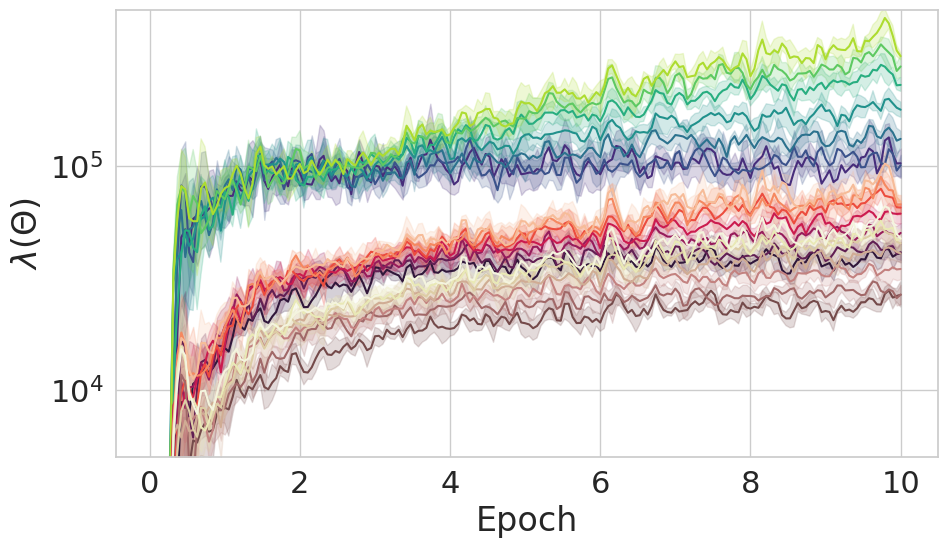

In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
fig, ax = plt.subplots(figsize = (10,6))

metrics = [f"ntk_eig_{i}" for i in [0, 4, 9]]
palettes = ['viridis', 'rocket', 'pink']
epoch = 9

    
for metric, palette in zip(metrics, palettes):
    run_ds = get_data(folder_path, epoch=epoch)
    df = loss_curves(run_ds)
    lrs = sorted(df['lr'].unique())
    #df = df[df["step"].isin(np.arange(0, df["step"].max())[::8])]
    if width_mult:
        df["width"] = df["width_mult"] * 64
    df["Width"] = df["width"]
    df = df.astype({"Width": np.int32})
    
    df = df[~df[metric].isna()]
    
    df["coeff"] = df["Width"]
    df[metric] = df[metric] * df["coeff"]
    df = df[df['lr'] == lrs[0]]
    
    # df = df[df[metric] > 9e-2]
    df[metric] = df[metric].rolling(2).mean()
    df = df.dropna()
    # df[df["step"] > 2]
    
    df[r"$\lambda$"] = df[metric]
    df["Step"] = df["step"]
    df['Epoch'] = (df['step']/df['step'].max()) * (epoch + 1)
    # df_max = df[df["width"] == df["width"].max()]
    # df = df[df["width"] != df["width"].max()]
    
    n_colors = len(df["Width"].unique())

    print(f"plotting {metric}")

    palette_sns = sns.color_palette(palette, n_colors=n_colors)
    sns.lineplot(data=df, x='Epoch', y=r"$\lambda$", hue="Width", style= "lr", markersize=8, palette=palette_sns, legend=False, ax=ax)

lrs = df["lr"].unique()
print(lrs)
# plt.hlines(2/lrs, 0, df["Step"].max(), linestyle="dashed")

plt.ylabel("$\lambda(\Theta)$")

# plt.arrow(11,1.2e-1,8,0,width=0.02, color='black')

plt.yscale('log')
#plt.ylim(0.8, 2.6)
#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
# plt.ylim(1e-1, 11)


fig.tight_layout()

widths = np.asarray(df["width"].unique())


# cbaxes = ax.inset_axes([0.6, 0.3, 0.37, 0.04])
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(widths.min(), widths.max()), cmap=palettes[0]),
    # cax=cbaxes, orientation='horizontal', label='Width --->')
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.set_label("")
# ax.text(5, 1200, r'$\lambda_{\max}$', color='black')

# cbaxes = ax.inset_axes([0.6, 0.2, 0.37, 0.04])
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(widths.min(), widths.max()), cmap=palettes[1]),
#     cax=cbaxes, orientation='horizontal', label='Width --->')
# cbar.set_ticks([])
# cbar.set_ticklabels([])
# cbar.set_label("")
# ax.text(cbaxes.get_xlim()[0], cbaxes.get_ylim()[0], r'$\lambda_4$', color='black')
# ax.text(5.5, 490, r'$\lambda_4$', color='black')

# cbaxes = ax.inset_axes([0.6, 0.1, 0.37, 0.04])
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(widths.min(), widths.max()), cmap=palettes[2]),
#     cax=cbaxes, orientation='horizontal', label='Width --->')
# cbar.set_ticks([widths.min(), widths.max()])
# cbar.set_ticklabels([int(widths.min()), int(widths.max())])
# cbar.set_label("Width", labelpad=-25)
# ax.text(cbaxes.get_xlim()[0], cbaxes.get_ylim()[0], r'$\lambda_10$', color='black')
# ax.text(5.23, 180, r'$\lambda_{10}$', color='black')

plt.ylim(5e3, 5e5)
# plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
# plt.savefig("ntk_top_eigenvalues_cifar10_conv_data_augm_mup.pdf", format='pdf', bbox_inches='tight')
# plt.savefig("Figures/Neurips/strong_cons_top_k_cifar10_resnet_conv_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')

plotting ntk_eig_0
plotting ntk_eig_4
plotting ntk_eig_9
[1.221677]


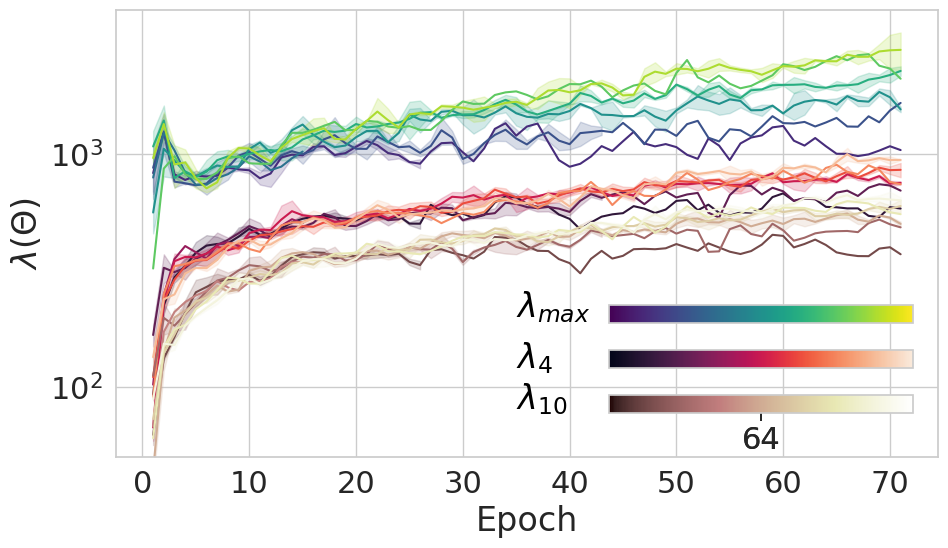

In [55]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
fig, ax = plt.subplots(figsize = (10,6))

metrics = [f"ntk_eig_{i}" for i in [0, 4, 9]]
palettes = ['viridis', 'rocket', 'pink']
# palettes = ['rocket', 'pink']
epoch = 70

    
for metric, palette in zip(metrics, palettes):
    run_ds = get_data(folder_path, epoch=epoch)
    df = loss_curves(run_ds)
    df['depth'] = df['depth_mult'] * 3
    lrs = sorted(df['lr'].unique())
    #df = df[df["step"].isin(np.arange(0, df["step"].max())[::8])]
    if width_mult:
        df["width"] = df["width_mult"] * 64
    df["Depth"] = df["depth"]
    df = df.astype({"Depth": np.int32})
    
    df = df[~df[metric].isna()]
    
    df["coeff"] = df["Depth"]
    # df[metric] = df[metric] * df["coeff"]
    df = df[df['lr'] == lrs[10]]
    # df = df[df[metric] > 9e-2]
    # import pdb
    # pdb.set_trace()
    df[metric] = df[metric].rolling(2).mean()
    
    df = df[df["step"] >= 1]
    
    df[r"$\lambda$"] = df[metric]
    df["Step"] = df["step"]
    df['Epoch'] = (df['step']/df['step'].max()) * (epoch + 1)
    # df_max = df[df["width"] == df["width"].max()]
    # df = df[df["width"] != df["width"].max()]
    
    n_colors = len(df["Depth"].unique())

    print(f"plotting {metric}")

    palette_sns = sns.color_palette(palette, n_colors=n_colors)
    sns.lineplot(data=df, x='Epoch', y=r"$\lambda$", hue="Depth", style= "lr", markersize=8, palette=palette_sns, legend=False, ax=ax)

lrs = df["lr"].unique()
print(lrs)
# plt.hlines(2/lrs, 0, df["Step"].max(), linestyle="dashed")

plt.ylabel("$\lambda(\Theta)$")

# plt.arrow(11,1.2e-1,8,0,width=0.02, color='black')

plt.yscale('log')
plt.ylim(bottom=50)
#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
# plt.ylim(1e-1, 11)


fig.tight_layout()

widths = np.asarray(df["width"].unique())


cbaxes = ax.inset_axes([0.6, 0.3, 0.37, 0.04])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(widths.min(), widths.max()), cmap=palettes[0]),
    cax=cbaxes, orientation='horizontal')
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.set_label("")
ax.text(35, 200, r'$\lambda_{max}$', color='black')

cbaxes = ax.inset_axes([0.6, 0.2, 0.37, 0.04])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(widths.min(), widths.max()), cmap=palettes[1]),
    cax=cbaxes, orientation='horizontal')
cbar.set_ticks([])
cbar.set_ticklabels([])
cbar.set_label("")
# ax.text(cbaxes.get_xlim()[0], cbaxes.get_ylim()[0], r'$\lambda_10$', color='black')
ax.text(35, 120, r'$\lambda_{4}$', color='black')

cbaxes = ax.inset_axes([0.6, 0.1, 0.37, 0.04])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(widths.min(), widths.max()), cmap=palettes[2]),
    cax=cbaxes, orientation='horizontal')
cbar.set_ticks([widths.min(), widths.max()])
cbar.set_ticklabels([int(widths.min()), int(widths.max())])
# cbar.set_label("Width", labelpad=-25)
# ax.text(cbaxes.get_xlim()[0], cbaxes.get_ylim()[0], r'$\lambda_10$', color='black')
ax.text(35, 80, r'$\lambda_{10}$', color='black')

# plt.ylim(5e3, 5e5)
# plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
# plt.savefig("ntk_top_eigenvalues_cifar10_conv_data_augm_mup.pdf", format='pdf', bbox_inches='tight')
# plt.savefig("Figures/Neurips/strong_cons_top_k_cifar10_resnet_conv_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')
plt.savefig("cifar10_conv_sharpness_k2_top_ntk_eigs.pdf", format='pdf', bbox_inches='tight')

In [ ]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))

metric = "trace"
epoch = 9
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

df = df[~df[metric].isna()]

if width_mult:
    df["width"] = df["width_mult"] * 64

df["Width"] = df["width"]
#df = df[df["lr"] == 8] 

#df = df.groupby(["Depth", "seed", "lr"], as_index=False).rolling(3).mean()
df = df[~df[metric].isna()]
#df["step"] = df["step"] / df["step"].max() * epoch

df["coeff"] = df["Width"]
df[metric] = df[metric] * df["coeff"]

# df_best_lr = df[df["step"] == max(df["step"])]
# df_best_lr = df_best_lr.reset_index(drop=True)
# df_best_lr = df_best_lr.loc[df_best_lr.groupby(["width_mult", "Depth"])["train_loss"].idxmin()]
# lrs = df_best_lr[df_best_lr["Depth"].isin([3, 24])]["lr"]
# df[metric] = df[metsric].rolling(2).mean()
# df = df.dropna()

df = df.astype({"Width": np.int32})
df[r"$\lambda$"] = df[metric]
df["Step"] = df["step"]

df_max = df[df["width"] == df["width"].max()]
df = df[df["width"] != df["width"].max()]

n_colors = len(df["Width"].unique())


ax = sns.lineplot(data=df, x='Step', y=r"$\lambda$", hue="Width", style= "lr", markersize=8, palette=sns.color_palette("viridis", n_colors=n_colors), legend=True)
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
ax = sns.lineplot(data=df_max, x='Step', y=r"$\lambda$", hue="Width", style= "lr", markersize=8, palette=['r'], legend=True)


# lrs = df["lr"].unique()
# print(lrs)
# plt.hlines(2/lrs, 0, df["Step"].max(), linestyle="dashed")


plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
plt.ylabel("$\lambda$")
plt.yscale('log')
#plt.ylim(0.8, 2.6)
#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
#plt.ylim(0.8, 2.4)
#plt.savefig("Figures/cifar10_conv_sharpness_ntk_width_data_augm_bs128.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')

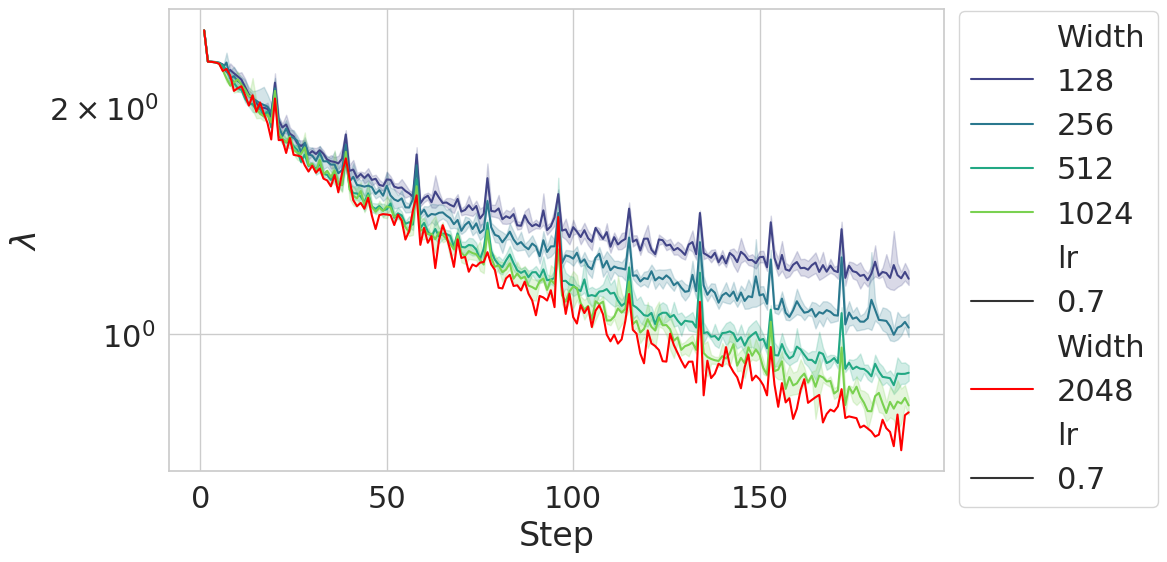

In [16]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))

metric = "train_loss"
epoch = 9
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

df = df[~df[metric].isna()]

if width_mult:
    df["width"] = df["width_mult"] * 64
    
df["Width"] = df["width"]
#df = df[df["lr"] == 8] 

#df = df.groupby(["Depth", "seed", "lr"], as_index=False).rolling(3).mean()
df = df[~df[metric].isna()]
#df["step"] = df["step"] / df["step"].max() * epoch


# df_best_lr = df[df["step"] == max(df["step"])]
# df_best_lr = df_best_lr.reset_index(drop=True)
# df_best_lr = df_best_lr.loc[df_best_lr.groupby(["width_mult", "Depth"])["train_loss"].idxmin()]
# lrs = df_best_lr[df_best_lr["Depth"].isin([3, 24])]["lr"]
# df[metric] = df[metsric].rolling(2).mean()
# df = df.dropna()

df = df.astype({"Width": np.int32})
df[r"$\lambda$"] = df[metric]
df["Step"] = df["step"]

df_max = df[df["width"] == df["width"].max()]
df = df[df["width"] != df["width"].max()]

n_colors = len(df["Width"].unique())


ax = sns.lineplot(data=df, x='Step', y=r"$\lambda$", hue="Width", style= "lr", markersize=8, palette=sns.color_palette("viridis", n_colors=n_colors), legend=True)
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
ax = sns.lineplot(data=df_max, x='Step', y=r"$\lambda$", hue="Width", style= "lr", markersize=8, palette=['r'], legend=True)



plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
plt.ylabel("$\lambda$")
plt.yscale('log')

#ax.set_yticks([0.1, 0.2, 0.05, 0.4])
#ax.set_yticklabels([r"$10^{-1}$", r"$2\times 10^{-1}$", r"$5\times 10^{-2}$", r"$4\times 10^{-1}$"])
# plt.ylim(1/max(lrs), 2.5/min(lrs))
#plt.ylim(0.04, 0.4)
#plt.savefig("Figures/cifar10_conv_sharpness_ntk_width_data_augm_bs128.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/cifar10_conv_sharpness_sp_width_no_data_augm_bs128_early.pdf", format='pdf', bbox_inches='tight')
#plt.savefig("Figures/Rebuttal/cifar10_conv_sharpness_mup_data_augm_wm_200.pdf", format='pdf', bbox_inches='tight')

In [87]:
# Power law fit:

from scipy.optimize import curve_fit

def power_law(x, A, B):
    return A * x**B
    
def power_law_fit(x, y):

    # Fit the power law model to the data
    popt, pcov = curve_fit(power_law, x, y, maxfev=10000, p0 = np.asarray([0.5, 0.4]))

    # Extract the fitting parameters
    A, B = popt
    print(f"Fitted parameters: A = {A}, B = {B}")
    return A, B

[ 512.   32.  256.  128.   64. 1024. 2048.]
[ 32.  64. 128. 256. 512.]
     train_loss  width  step  seed  \
104    1.667960   32.0   104     3   
117    1.660842   32.0   117     3   
133    1.598247   32.0   133     3   
150    1.585069   32.0   150     3   
169    1.619371   32.0   169     3   
..          ...    ...   ...   ...   
104    1.094320  512.0   104     2   
117    1.092239  512.0   117     2   
133    1.044949  512.0   133     2   
150    0.933651  512.0   150     2   
169    0.956305  512.0   169     2   

     $|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$  Step  Width  
104                                      0.634766   104     32  
117                                      0.657181   117     32  
133                                      0.677680   133     32  
150                                      0.721481   150     32  
169                                      0.777218   169     32  
..                                            ...   ...    ...  
104              

/tmp/ipykernel_4064854/1977125552.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs(df_t[metric1] - df_max[metric1])
/tmp/ipykernel_4064854/1977125552.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs(df_t[metric1] - df_max[metric1])
/tmp/ipykernel_4064854/1977125552.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

    Step  seed  Width  $|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$
0    104     1     32                                      0.597323
1    104     1     64                                      0.423841
2    104     1    128                                      0.318111
3    104     1    256                                      0.184741
4    104     1    512                                      0.085088
..   ...   ...    ...                                           ...
70   169     3     32                                      0.777218
71   169     3     64                                      0.626327
72   169     3    128                                      0.427973
73   169     3    256                                      0.290782
74   169     3    512                                      0.102547

[75 rows x 4 columns]
Fitted parameters: A = 0.04048792608047671, B = 0.5835473755685304
Fitted parameters: A = 0.03171930087039877, B = 0.579976179562681
Fitted parameters: A = 0.019

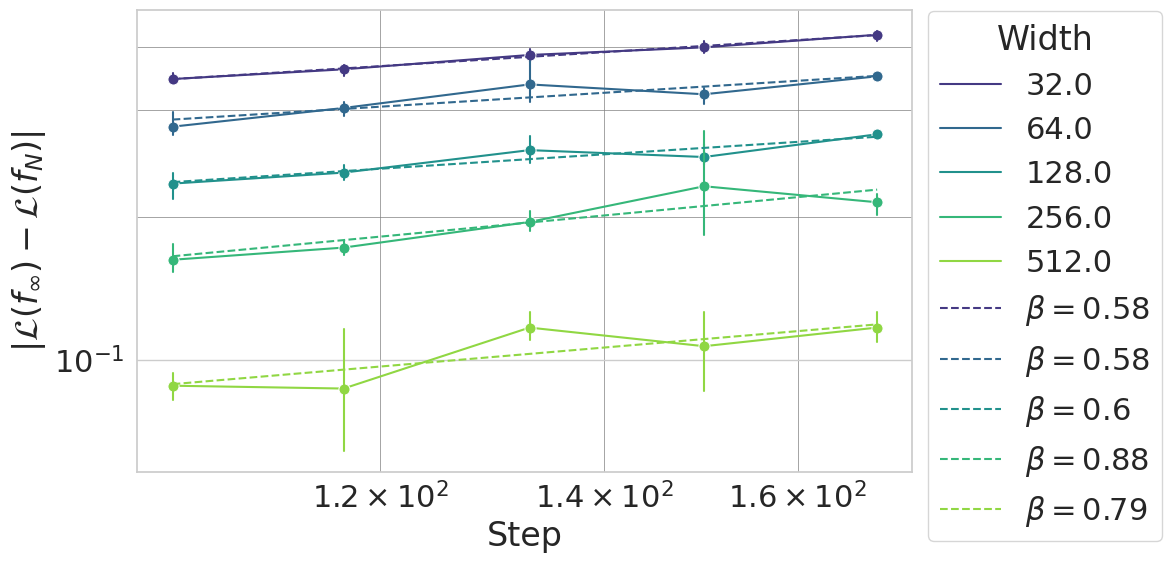

In [88]:
from matplotlib.patches import Rectangle

sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
fig, ax = plt.subplots(figsize=(10, 6))
metric1 = "train_loss"

epoch = 9
#chosen_widths = [4, 8, 16, 32, 64, 128, 256]
chosen_widths = [32, 64, 128, 256, 512]
max_width = 2048
name = r"$|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$"

run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

if width_mult:
    df["width"] = df["width_mult"] * 64
    
df = df[[metric1, "width", "step", "seed"]]
#df = df[df["step"].isin(chosen_steps)]

df = df[~df[metric1].isna()]

print(df["width"].unique())


# df["coeff"] = df["width"]
# df[metric1] = df[metric1] * df["coeff"]

seeds = df["seed"].unique()
steps = df["step"].unique()
dfs = []
for s in seeds:
    for t in chosen_widths:
        df_t = df[(df["width"] == t) & (df["seed"] == s)]
        df_max = df[(df["width"] == max_width) & (df["seed"] == s)]
        df_t[name] = np.abs(df_t[metric1] - df_max[metric1])
        dfs.append(df_t)
df = pd.concat(dfs)

df[name] = df[name].rolling(2).mean()
df = df.dropna()

steps = np.unique(np.logspace(np.log10(1),np.log10(400), num=50, base=10).astype(int))
df = df[df["step"].isin(steps)]
df = df[df["step"] > 100]

df["Step"] = df["step"]

df["Width"] = df["width"]

print(df["Width"].unique())
df = df.astype({"Width": np.int32})
print(df)
palette = sns.color_palette("viridis", n_colors=len(chosen_widths))
sns.lineplot(data=df, x='Step', y=name, hue="width",  markersize=8, palette=palette, legend=True, marker='o', err_style='bars', ax=ax)



df = df[["Step", "seed", "Width", name]]

res = df.groupby(["Step", "seed", "Width"], as_index=False).mean()
print(res)

ax.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
handles, labels = ax.get_legend_handles_labels()

title_proxy = Rectangle((0,0), 0, 0, color='w')
c_handles = [title_proxy]
c_labels = [r"$\beta$"]
for n in df["Width"].unique():
    df_n = res[res["Width"] == n]
    x = df_n["Step"]
    y = df_n[name]
    A, B = power_law_fit(np.asarray(x), np.asarray(y))
    label = r'$\beta = {{{}}}$'.format(str(round(B, 2)))
    c_labels.append(label)
    ax.plot(x, power_law(x, A, B), linestyle="dashed", label=label)
    
ax.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")


ax.set_ylabel(name)
#
ax.set(xscale="log", yscale="log")

def skip_ticks(x, pos):
    print(x)
    if pos % 2 == 0:  # Show labels only for powers of 10
        m = np.log10(x) % 10
        return f'${m:.1%} x 10^{int(np.log10(x))}$'
    else:
        return ''
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, LogLocator, LogFormatter

ax.grid(True, which='minor', linestyle='-', linewidth=0.5, color='gray')
# ax.set_xticklabels([])
# #ax.tick_params(axis='x', which='both', labelbottom=False)

# ax.set_yticklabels([])

# print(ax.get_xticks())
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
# ax.set_xticklabels(xlabels)

#ax.xaxis.set_minor_locator(MultipleLocator(10)) 
ax.xaxis.set_minor_locator(plt.MaxNLocator(4))
ax.yaxis.set_minor_locator(plt.MaxNLocator(4))
# ax.xaxis.set_minor_formatter(LogFormatter(base=10.0))
# ax.xaxis.set_minor_formatter(FuncFormatter(skip_ticks))

# # Set the locator and formatter for the x-axis
# ax.xaxis.set_minor_locator(MultipleLocator(1))  # x-axis ticks every 1 unit
# ax.xaxis.set_minor_formatter(FuncFormatter(skip_ticks))

# ax.yaxis.set_major_locator(LogLocator(base=10.0))
# ax.yaxis.set_major_locator(MultipleLocator(0.2))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format tick labels
# 
plt.savefig("Figures/Neurips/not_strong_cons_loss_cifar10_resnet_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')

In [4]:
# Power law fit:

from scipy.optimize import curve_fit

def power_law(x, A, B):
    return A * x**B
    
def power_law_fit(x, y):

    # Fit the power law model to the data
    popt, pcov = curve_fit(power_law, x, y, maxfev=10000)

    # Extract the fitting parameters
    A, B = popt
    print(f"Fitted parameters: A = {A}, B = {B}")
    return A, B

In [ ]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=3))
plt.figure(figsize = (10,6))
metric1 = "ntk_eig_0"

dist_from_eos = False
abs_value = True

epoch = 9
chosen_widths = [32, 128, 512]
max_width = 2048

name = r"$|\lambda_{\max}(\Theta_\infty) - \lambda_{\max}(\Theta_N)|$"
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

# eos = 2/float(np.asarray(df["lr"])[0])

if width_mult:
    df["width"] = df["width_mult"] * 64
    
df = df[[metric1, "width", "step", "seed"]]
#df = df[df["step"].isin(chosen_steps)]

df = df[~df[metric1].isna()]

# print(df["width"].unique())

steps = np.unique(np.logspace(np.log10(1),np.log10(400), num=50, base=10).astype(int))
df = df[df["step"].isin(steps)]
df = df[df["step"] > 50]


df["coeff"] = df["width"]
df[metric1] = df[metric1] * df["coeff"]



df[metric1] = df[metric1].rolling(3).mean()
df = df.dropna()
df = df[~df[metric1].isna()]

# print(df)

seeds = df["seed"].unique()
steps = df["step"].unique()
dfs = []
for s in seeds:
    for t in chosen_widths:
        df_t = df[(df["width"] == t) & (df["seed"] == s)]
        df_max = df[(df["width"] == max_width) & (df["seed"] == s)]
        if not dist_from_eos:
            df_t[name] = df_t[metric1] - df_max[metric1]
        else:
            df_t[name] = df_t[metric1] - eos
        if abs_value:
            df_t[name] = np.abs(df_t[name])
        dfs.append(df_t)
df = pd.concat(dfs)



# steps = np.unique(np.linspace(1,400, num=50)).astype(int)
# df = df[df["step"].isin(steps)]

df["Step"] = df["step"]
df["Width"] = df["width"]

# print("Widths")
df = df[~df["Width"].isna()]
# print(df["Width"].unique())
df = df.astype({"Width": np.int32})

df = df[~df[name].isna()]
df['Epoch'] = (df['Step']/df['Step'].max())*epoch
df = df[df['Epoch'] >= 5.0]
ax = sns.lineplot(data=df, x='Epoch', y=name, hue="Width",  markersize=12, marker='o', linewidth = 5.0, palette=sns.color_palette("viridis", n_colors=3), legend=True, err_style='bars')
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
# xs = df["width"].unique()
# xs.sort()
# ys = (1/np.sqrt(xs))*np.sqrt(xs[0])
# plt.plot(xs, ys, linestyle='dashed', color='black')

# plt.hlines(1e-1, 0, max(df["Step"]), linestyle="dashed", colors='black')

# ys = np.sqrt(xs / xs[0]) * 5*10**(-3)
# plt.plot(xs, ys, linestyle='dashed', color='black')
# ys = (1/xs)*xs[0]
# plt.plot(xs, ys, linestyle='dashed', color='black')
df = df[["Epoch", "seed", "Width", name]]

res = df.groupby(["Epoch", "seed", "Width"], as_index=False).mean()
# print(res)

for n in df["Width"].unique():
    df_n = res[res["Width"] == n]
    x = df_n["Epoch"]
    y = df_n[name]
    A, B = power_law_fit(np.asarray(x), np.asarray(y))
    ax.plot(x, power_law(x, A, B), label=r'$\beta = {{{}}}$'.format(str(round(B, 2))), linestyle="dashed", linewidth = 2.0)
    
ax.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
ax.set_ylabel(name)



# plt.ylim(2e-2, 2.5)
#plt.xlim(df["Step"].min(), df["Step"].max())
plt.yscale('log')
plt.xscale('log')

# from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, LogLocator, LogFormatter

# ax.grid(True, which='minor', linestyle='-', linewidth=0.5, color='gray')
# # ax.set_xticklabels([])
# # #ax.tick_params(axis='x', which='both', labelbottom=False)

# # ax.set_yticklabels([])

# # print(ax.get_xticks())
# # xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
# # ax.set_xticklabels(xlabels)

# #ax.xaxis.set_minor_locator(MultipleLocator(10)) 
# ax.xaxis.set_minor_locator(plt.MaxNLocator(4))
# ax.yaxis.set_minor_locator(plt.MaxNLocator(4))

plt.savefig("ntk_topeig_vs_time_cifar10_convnets_mup.pdf", format='pdf', bbox_inches='tight')


/tmp/ipykernel_2843462/2971688950.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = df_t[metric1] - df_max[metric1]
/tmp/ipykernel_2843462/2971688950.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs(df_t[name])
/tmp/ipykernel_2843462/2971688950.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Fitted parameters: A = 1689.1371662167908, B = 2.245843834427037
Fitted parameters: A = 2712.2560562814615, B = 1.9607626164693654
Fitted parameters: A = 576.7642298975923, B = 2.3327754672542316


[ 512.  256. 1024.  128.   64. 2048.   32.]


/tmp/ipykernel_3759094/3047962903.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_metric = float(df_t[df_t["width"] == df_t["width"].max()][metric])
/tmp/ipykernel_3759094/3047962903.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs((df_t[metric] - max_metric))
/tmp/ipykernel_3759094/3047962903.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_metric = float(df_t[df_t["width"] == df_t["width"].max()][metric])
/tmp/ipykernel_3759094/3047962903.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of

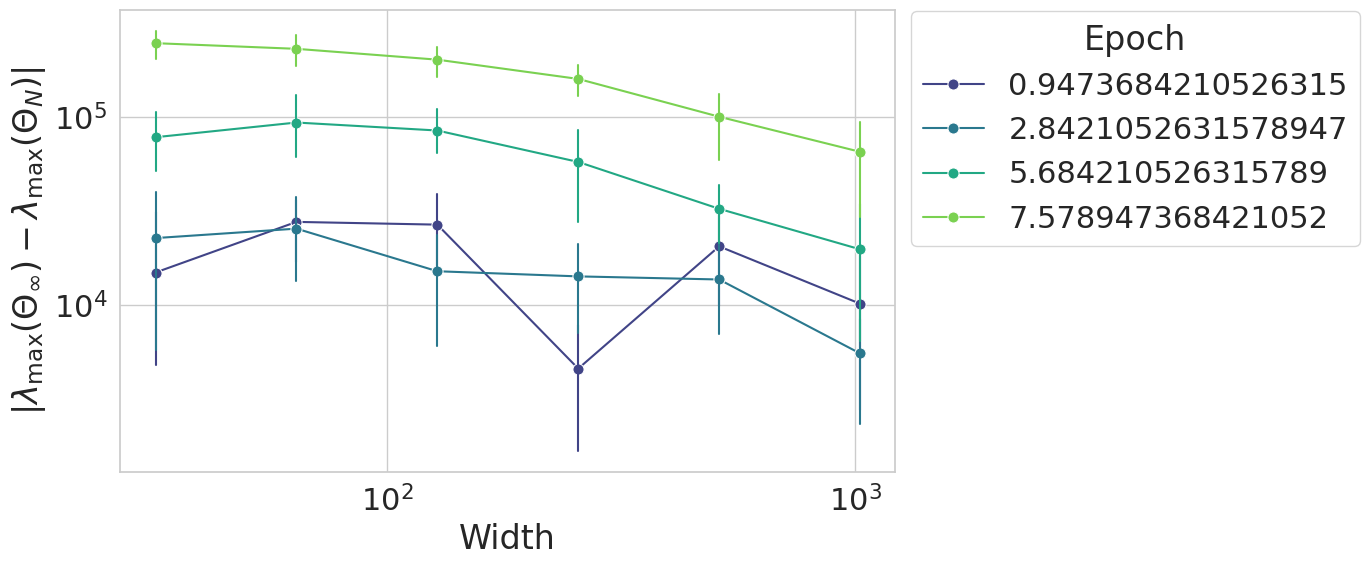

In [64]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
metric = "ntk_eig_0"
epoch = 9
#chosen_steps = [195, 250, 350, 390]
chosen_steps = [20, 60, 120, 160]
# chosen_epochs = [1.0, 3.0, 6.0, 8.0]
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

if width_mult:
    df["width"] = df["width_mult"] * 64

df = df[~df[metric].isna()]
df['Epoch'] = (df['step']/df['step'].max())*epoch
name = r"$|\lambda_{\max}(\Theta_\infty) - \lambda_{\max}(\Theta_N)|$"

df = df[[metric, "width", "step", "seed", 'Epoch']]
    
print(df["width"].unique())

df = df[df["width"].isin([32, 64, 128, 256, 512, 1024, 2048])]
df["coeff"] = df["width"]
df[metric] = df[metric] * df["coeff"]

df[metric] = df[metric].rolling(2).mean()
df = df.dropna()

seeds = df["seed"].unique()
dfs = []
for s in seeds:
    for t in chosen_steps:
        df_t = df[(df["step"] == t) & (df["seed"] == s)]
        max_metric = float(df_t[df_t["width"] == df_t["width"].max()][metric])
        df_t[name] = np.abs((df_t[metric] - max_metric))
        dfs.append(df_t)
df = pd.concat(dfs)

df = df[df["step"].isin(chosen_steps)]



df["Step"] = df["step"]
df["Width"] = df["width"]

df = df[df["Width"] != df["Width"].max()]

df = df.astype({"Width": np.int32})
# df['Epoch'] = np.ceil(df['Epoch']).astype(int)
ax = sns.lineplot(data=df, x='Width', y=name, hue="Epoch",  markersize=8, marker='o', palette=sns.color_palette("viridis", n_colors=len(chosen_steps)), legend=True, err_style="bars")
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
xs = df["width"].unique()

# xs.sort()
# ys = (1/np.sqrt(xs))*np.sqrt(xs[0])
# plt.plot(xs, ys, linestyle='dashed', color='black')


# plt.hlines(2e-1, 0, max(df["width"]), linestyle="dashed", colors='black')
#ys = (1/xs)*xs[0]
#plt.plot(xs, ys, linestyle='dashed', color='black')
# plt.hlines(0.35, 7, max(xs), linestyle="dashed", colors='black')

# ys = (1/xs)*xs[0]
# plt.plot(xs, ys, linestyle='dashed', color='black')

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Epoch")
plt.ylabel(name)
# plt.ylim(2e-2, 8)
plt.yscale('log')
plt.xscale('log')

#from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, LogLocator, LogFormatter

#ax.grid(True, which='minor', linestyle='-', linewidth=0.5, color='gray')
# ax.set_xticklabels([])
# #ax.tick_params(axis='x', which='both', labelbottom=False)

# ax.set_yticklabels([])

# print(ax.get_xticks())
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
# ax.set_xticklabels(xlabels)

#ax.xaxis.set_minor_locator(MultipleLocator(10)) 
# ax.xaxis.set_minor_locator(plt.MaxNLocator(3))
#ax.yaxis.set_minor_locator(plt.MaxNLocator(4))

# plt.savefig("Figures/Neurips/strong_cons_sharp_width_cifar10_resnet_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')
# plt.savefig("ntk_topeig_vs_width_cifar10_convnets_mup.pdf", format='pdf', bbox_inches='tight')

In [78]:
# Power law fit:

from scipy.optimize import curve_fit

def power_law(x, A, B):
    return A * x**-B
    
def power_law_fit(x, y):

    # Fit the power law model to the data
    popt, pcov = curve_fit(power_law, x, y, maxfev=10000)

    # Extract the fitting parameters
    A, B = popt
    print(f"Fitted parameters: A = {A}, B = {B}")
    return A, B

[128   8  64  32  16  -1 256 512]
        trace  top_eig_0  top_eig_1  top_eig_2  top_eig_3  top_eig_4  \
20   0.068729   0.010734   0.008590   0.006654   0.005960   0.004778   
20   0.698501   0.079743   0.058558   0.052329   0.043736   0.031139   
20   0.249033   0.028799   0.019208   0.011391   0.010351   0.009199   
20   0.479599   0.044658   0.036452   0.031247   0.027630   0.022510   
20   0.163671   0.020020   0.013344   0.009939   0.007978   0.006916   
..        ...        ...        ...        ...        ...        ...   
160  1.420252   0.037269   0.028299   0.026990   0.022605   0.020411   
160  0.589282   0.009394   0.007769   0.006624   0.006468   0.006171   
160  1.036344   0.017586   0.015414   0.013869   0.012692   0.012129   
160  1.989193   0.069471   0.046374   0.042751   0.038378   0.034667   
160  0.161560   0.001818   0.001686   0.001526   0.001351   0.001156   

     top_eig_5  top_eig_6  top_eig_7  top_eig_8  ...  width_mult  width  \
20    0.003751   0.002634 

/tmp/ipykernel_4064854/502744070.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs(df_t[metric] - max_metric) / max_metric
/tmp/ipykernel_4064854/502744070.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs(df_t[metric] - max_metric) / max_metric
/tmp/ipykernel_4064854/502744070.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

     Step  seed  Width  $|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$
20     20     5    128                                      0.000000
20     20     5      8                                      0.084195
20     20     5     32                                      0.071452
20     20     5     16                                      0.050623
20     20     5     64                                      0.012038
..    ...   ...    ...                                           ...
160   160     2      8                                      0.970708
160   160     2     32                                      0.492802
160   160     2    128                                      0.154039
160   160     2     64                                      0.344217
160   160     2     16                                      0.749681

[88 rows x 4 columns]
    seed  Step  Width  $|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$
0      2    20      8                                      0.066034
1      2    2

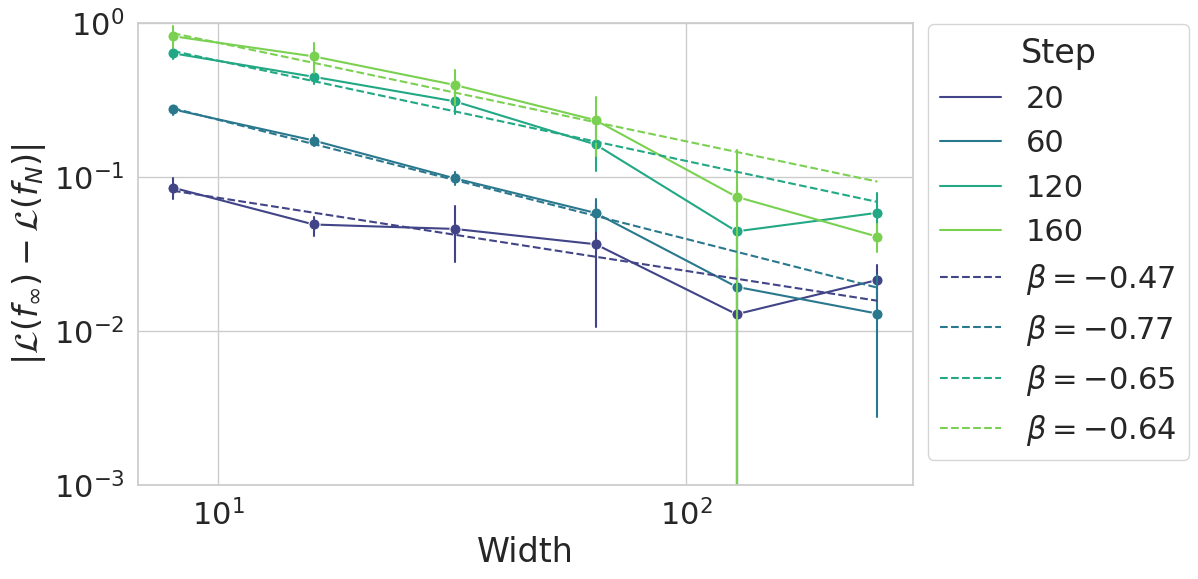

In [91]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=4))
plt.figure(figsize = (10,6))
metric = "train_loss"
epoch = 9
chosen_steps = [20, 60, 120, 160]
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)

df = df[~df[metric].isna()]

print(df["width"].unique())

df = df[df["width"].isin([2, 4, 8, 16, 32, 64, 128, 256, 512, 2048])]

name = r"$|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$"
# df[metric] = df[metric].rolling(2).mean()
# df = df.dropna()
df[metric] = df[metric].rolling(2).mean()
df = df.dropna()

seeds = df["seed"].unique()
dfs = []
for s in seeds:
    for t in chosen_steps:
        df_t = df[(df["step"] == t) & (df["seed"] == s)]
        max_metric = float(df_t[df_t["width"] == df_t["width"].max()][metric])
        df_t[name] = np.abs(df_t[metric] - max_metric) / max_metric
        dfs.append(df_t)
df = pd.concat(dfs)
print(df)

df = df[df["step"].isin(chosen_steps)]

# df[name] = df[name].rolling(2).mean()
# df = df.dropna()

df["Step"] = df["step"]
df["Width"] = df["width"]
df = df[df["Width"] != df["Width"].max()]

print(df["Width"].unique())
df = df.astype({"Width": np.int32})

ax = sns.lineplot(data=df, x='Width', y=name, hue="Step",  markersize=8, marker='o', palette=sns.color_palette("viridis", n_colors=len(chosen_steps)), legend=True, err_style="bars")
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
xs = df["width"].unique()
xs.sort()
# ys = (1/np.sqrt(xs))*np.sqrt(xs[0])*0.5
# plt.plot(xs, ys, linestyle='dashed', color='black')

# ys = (1/xs)*xs[0]*0.5
# plt.plot(xs, ys, linestyle='dashed', color='black')
# plt.hlines(0.35, 7, max(xs), linestyle="dashed", colors='black')

# ys = (1/xs)*xs[0]
# plt.plot(xs, ys, linestyle='dashed', color='black')

plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Step")



res = df[["Step", "seed", "Width", name]]

res = res[res["Step"].isin(chosen_steps)]

print(res)

res = res.groupby(["seed", "Step", "Width"], as_index=False).mean()
print(res)

#ax.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
#handles, labels = ax.get_legend_handles_labels()

title_proxy = Rectangle((0,0), 0, 0, color='w')
c_handles = [title_proxy]
c_labels = [r"$\beta$"]
for n in res["Step"].unique():
    print("-----")
    df_n = res[res["Step"] == n]
    df_n = df_n.groupby("Width", as_index=False).mean()
    x = df_n["Width"]
    y = df_n[name]
    A, B = power_law_fit(np.asarray(x), np.asarray(y))
    label = r'$\beta = {{{}}}$'.format(str(round(B, 2)))
    c_labels.append(label)
    #print(power_law(x, A, B))
    ax.plot(x, power_law(x, A, B), linestyle="dashed", label=label)
    
ax.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Step")


plt.ylabel(name)
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xscale('log')
plt.savefig("Figures/Neurips/not_strong_cons_loss_width_cifar10_resnet_sharpness_mup_data_augm.pdf", format='pdf', bbox_inches='tight')